## Error analysis on PAL5 photometry data

This notebook now calculates the uncertainty in the magnitude values calculated using aperture photometry on the Palomar 5 globular cluster

In [1]:
import math
import statistics
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits # FITS file management
from astropy.stats import sigma_clipped_stats # use within star detection
from photutils import aperture_photometry # used to perform photometry using apertures
from photutils import DAOStarFinder # star finding algorithm
from photutils import CircularAperture, CircularAnnulus

FLUXCONV = 0.1257
EXPTIME = 71.3724


Number of stars detected: 597


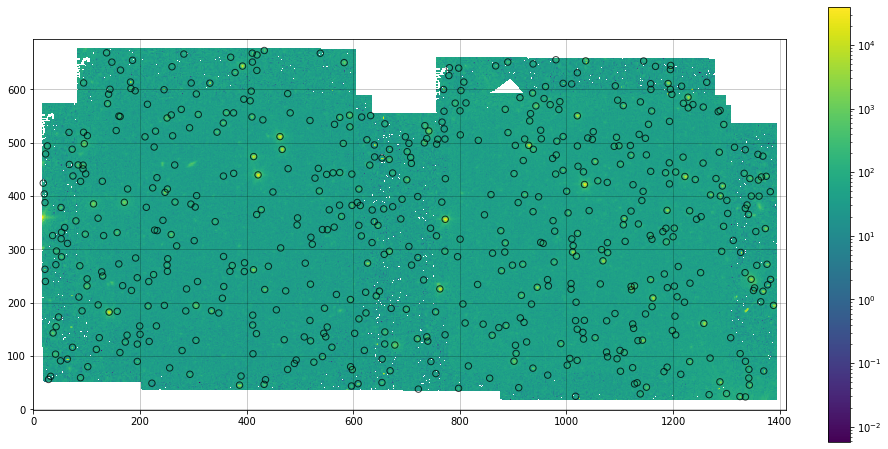

  aperture_sum_1  
------------------
               nan
               nan
               nan
               nan
               nan
               nan
               nan
               nan
20233.212470391518
25412.814395010013
               ...
               nan
25320.372733397824
               nan
               nan
 25240.24121175571
               nan
               nan
               nan
               nan
               nan
               nan
Length = 597 rows


In [2]:
## BASE DATA DIRECTORY ##

base_dir = 'PAL5_data/PAL5__e1/'
channel = '3p6um'

## PARAMETERS ##

sigma_val = 6.
fwhm = 5.
r_ap = 6.
r_in = 6.
r_out = 14.
roundlo = -0.5
roundhi = 0.5

## CHANNEL ##

if channel == '3p6um':
    aper_corr = 1.1233         # aperture correction for 337 (6,6,14) pixel apertures c.f IRAC
    ap_err = aper_corr * 0.02  # uncertainty to ~2% as per IRAC handbook
    zmag = 18.80               # zeropoint magnitude given in IRAC handbook
    zmag_err = 0.02            # uncertainty calculated from F0 = 280.9 +/- 4.1 in IRAC handbook
elif channel == '4p5um':
    aper_corr = 1.1336
    ap_err = aper_corr * 0.02
    zmag = 18.32
    zmag_err = 0.02 
    
## OPENING FITS FILE AND EXTRACTING DATA ##

file = base_dir+'PAL5__e1_'+channel+'.fits'

with fits.open(file) as header_list:
    header = header_list[0].header
    fluxconv = header['FLUXCONV']
    exptime = header['EXPTIME']
    counts = exptime / fluxconv
    image_data = fits.getdata(file, ext = 0)
    data = image_data * counts
    print('FLUXCONV = {}\nEXPTIME = {}'.format(fluxconv, exptime))
    
# extracting correction data

corr_file = base_dir+'PAL5__e1_correction_'+channel+'.fits'

with fits.open(corr_file) as hdu_list:
    corr_data = hdu_list[0].data
        
## SOURCE DETECTION ##
mean_val, median_val, std_val = sigma_clipped_stats(data, sigma = sigma_val)

daofind = DAOStarFinder(fwhm = fwhm, threshold = sigma_val * std_val, roundlo = roundlo, roundhi = roundhi)
sources = daofind(data) #- median_val) # necessary here?
print('Number of stars detected: {}'.format(len(sources)))
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r = 6.)

plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
plt.colorbar(fraction = 0.05)
apertures.plot(color = 'black', lw = 1., alpha = .75)
#plt.title('Aperture photometry on epoch {} in channel {}: sigma = {}, fwhm = {}, roundlo = {}, roundhi = {}'
#          .format(j, channel, sigma_val, fwhm, roundlo, roundhi))
plt.grid(b = True, which = 'major', lw = .5, alpha = .4, color = 'black')
plt.gcf().set_size_inches(15, 8)
#plt.savefig(r'aperture_photometry_output_images/aperture_phot_epoch{}_channel{}.png'.format(j, channel))
plt.show()
plt.close()

## APERTURE PHOTOMETRY ##

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
circular_apertures = CircularAperture(positions, r = r_ap)
annuli_apertures = CircularAnnulus(positions, r_in = r_in, r_out = r_out)
apertures = [circular_apertures, annuli_apertures]

# initial photometry table
phot_init = aperture_photometry(data, apertures)

# background subtraction using sigma-clipped median and annuli
annulus_masks = annuli_apertures.to_mask(method = 'center')

bkg_median = []
for mask in annulus_masks:
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0] # extract 1D array of data values
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d) # utilise sigma clipping on the annulus masks
    bkg_median.append(median_sigclip)

bkg_median = np.array(bkg_median)
# now append bkg_median, aperture background and aperture sum background values to photometry data
phot_init['annulus_median'] = bkg_median
phot_init['aper_bkg'] = bkg_median * circular_apertures.area
aper_sum_bkgsub = phot_init['aperture_sum_0'] - phot_init['aper_bkg']
phot_init['aper_sum_bkgsub'] = phot_init['aperture_sum_0'] - phot_init['aper_bkg']
print(phot_init['aperture_sum_1'])

In [6]:
## PHOTOMETRY: UNCERTAINTIES ##

# this follows section 2 (pp 8) of Reach et al 2005

mean_bkg = phot_init['aperture_sum_1'] / annuli_apertures.area
median_bkg = bkg_median

bkg_sub_err = median_bkg * circular_apertures.area / pow(annuli_apertures.area, 0.5)
sky_err = median_bkg * pow(circular_apertures.area, 0.5)
poisson_err = pow(phot_init['aper_sum_bkgsub'], 0.5)

aper_err = pow(bkg_sub_err**2 + sky_err**2 + poisson_err**2, 0.5)


## APPARENT MAGNITUDE ##

phot = phot_init                    # redefine photometry table for ease
phot['apparent_mag'] = float('NaN') # populate a new table (very quirky here, nans?)

for i in range(0, len(phot)):
    # array-location dependent correction
    loc_corr = corr_data[int(phot['ycenter'][i].value)][int(phot['xcenter'][i].value)]
    if phot['aper_sum_bkgsub'][i] >= 0:
        phot['apparent_mag'][i] = zmag - 2.5 * math.log10(phot['aper_sum_bkgsub'][i] * aper_corr * loc_corr / counts)

## APPARENT MAGNITUDE: UNCERTAINTIES ##

phot['apparent_mag_err'] = float('Nan')
for i in range(0, len(phot)):
    #phot['apparent_mag_err'][i] = np.sqrt(zmag_err**2 + (2.5 * np.sqrt((phot['aper_err'][i] / phot['aper_sum_bkgsub'][i])**2 + (ap_err / aper_corr)**2) / np.log(10))**2)
    phot['apparent_mag_err'][i] = pow(zmag_err**2 + (2.5*(pow((aper_err[i] / aper_sum_bkgsub[i])**2 + (ap_err / aper_corr)**2, 0.5) / (np.log(10)))**2), 0.5)

# export into csv file
phot['id', 'xcenter', 'ycenter', 'apparent_mag', 'apparent_mag_err'].write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\aperphot_err_01_epoch01.txt', format = 'csv', overwrite = True)
print(phot['id', 'xcenter', 'ycenter', 'apparent_mag', 'apparent_mag_err'])

 id      xcenter       ...    apparent_mag      apparent_mag_err  
           pix         ...                                        
--- ------------------ ... ------------------ --------------------
  1  1335.720143020897 ...                nan                  nan
  2 1017.0720463346273 ...                nan                  nan
  3 1325.4233008232586 ...                nan                  nan
  4 1267.5653109644136 ... 17.185296063688693  0.23787567189989398
  5 1138.3723108598422 ... 16.847198276163923  0.12280014795444302
  6 1300.2369547517922 ... 16.489141325374188  0.17507493656625878
  7  722.2239316998908 ...                nan                  nan
  8  797.6394285408744 ...                nan                  nan
  9  910.4856114937096 ... 17.525399335303618   0.1958142797931325
 10 1150.0528392801152 ...  15.13531836947663 0.036409976628038083
...                ... ...                ...                  ...
588 186.06820051159417 ...  18.19668541908159  0.4508823335110

C:\Users\lukeb\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.
